In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.distributions.normal import Normal as Gaussian

import torchtext
from torchtext import data, datasets
from torchtext.vocab import FastText

cuda = True if torch.cuda.is_available() else False #CUDA使用可能でTrue
device="cuda:0" if cuda else "cpu"
# randomを固定
SEED = 1
# random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

import matplotlib.pyplot as plt
%matplotlib inline
UNK_token=0
PAD_token=1
SOS_token=2
EOS_token=3

In [2]:
def tokenizer(text):
    malist = text.split()
    return malist

In [3]:
# 定数
MAXLEN=20 #paddingをバッチにかかわらず固定長にする
TAU=1/100 #softargmax用
num_epochs = 100
EMBED_SIZE=300
BATCH_SIZE=512
data_type="wiki_spm"
out_dir="./result/lstmae"

In [4]:
# 日本語用
TEXT = data.Field(sequential=True, tokenize=tokenizer,lower=True, include_lengths=True, init_token="<SOS>",eos_token="<EOS>", fix_length=MAXLEN, batch_first=True)
train, val, test = data.TabularDataset.splits(
        path='./data/', train=data_type+'_train.tsv',
        validation=data_type+'_valid.tsv', test=data_type+'_test.tsv', format='tsv',
        fields=[('Text', TEXT),])
TEXT.build_vocab(train)
train_iter, val_iter, test_iter = data.Iterator.splits((train, val, test), batch_sizes=(BATCH_SIZE, BATCH_SIZE, BATCH_SIZE),sort = False, device=torch.device(device))
vocab_size=len(TEXT.vocab.itos)

In [5]:
share_emb=nn.Embedding(vocab_size, EMBED_SIZE).to(device)

In [6]:
class RNNEncoder(nn.Module):
    def __init__(self, hidden_dim):
        super(RNNEncoder, self).__init__()
        self.lstm = nn.LSTM(EMBED_SIZE, hidden_dim, batch_first=True)

    def forward(self, x_emb):
        _, state = self.lstm(x_emb) # out, (h=(1,batch,hidden_dim), c)
        return state[0]

In [7]:
class RNNDecoder(nn.Module):
    def __init__(self, hidden_dim):
        super(RNNDecoder, self).__init__()
        self.maxlen=MAXLEN
        self.embedding=share_emb
        self.lstm = nn.LSTM(EMBED_SIZE, hidden_dim, batch_first=True)
        self.fc1=nn.Linear(hidden_dim, vocab_size)
        
    def forward(self, x_emb, h): #h=(1,batch,hidden_dim)
        logits = torch.tensor([]).to(device)
        sentence = torch.tensor([],dtype=torch.long).to(device)

        c=torch.zeros_like(h)
        hidden=(h,c)
        for i in range(self.maxlen):
            if i==0: # 教師入力するならここに
                lstm_input = torch.unsqueeze(x_emb[:,i,:],1)
            else:
                lstm_input=self.embedding(word)
            lstm_input=F.normalize(lstm_input,dim=-1)
            out,hidden=self.lstm(lstm_input, hidden)
                # out = (batch, 1, n_hid)
                # hidden = ((batch, 1, n_hid),(batch, 1, n_hid))
            logit = self.fc1(out) # logit = (batch, 1, vocab_size)
            word = torch.argmax(logit, dim=2)# word = (batch, 1)
        
            sentence = torch.cat([sentence, word],1)
            logits = torch.cat([logits,logit],1)   
        return logits, sentence

In [8]:
class VAE(nn.Module):
    def __init__(self, hidden_dim):
        super(VAE,self).__init__()
        self.embedding=share_emb
        self.maxlen=MAXLEN
        self.RNNEncoder = RNNEncoder(hidden_dim)
        self.RNNDecoder = RNNDecoder(hidden_dim)

    def forward(self, x): # x = (batch, max_len)
        x_emb = self.embedding(x)
        x_emb=F.normalize(x_emb,dim=-1)
        h=self.RNNEncoder(x_emb)
        logits, sentence=self.RNNDecoder(x_emb,h)
            # logits = (batch, max_len, vocab_size)
            # sentence = (batch, max_len)
            # 中身はindex

        # loss
        seq_logits = logits[:,:-1,:] # 一番最後の出力は無意味
        target = x[:,1:] # 一番最初の<SOS>を取り除く
        criterion = nn.CrossEntropyLoss(ignore_index=1)
        loss = 0
        for i in range(self.maxlen-1):
            loss += criterion(torch.squeeze(seq_logits[:,i,:]), torch.squeeze(target[:,i]))
        loss/=(self.maxlen-1)
        return loss, sentence

In [9]:
def train(epoch):
    model.train()
    epoch_loss = 0
    count=0
    for idx, batch in enumerate(train_iter):
        (x, x_l) = batch.Text
            # xには文章のID表現が、x_lにはxの単語数が入る
            # x=(batch, max_len)
        optimizer.zero_grad()
        loss, syn_sents=model(x)
        with torch.autograd.detect_anomaly(): #NaN検出
            loss.backward()
            optimizer.step()
        epoch_loss+=loss.item()
        count+=len(x)
        with open(out_dir+"/sentences/{:0>3}.txt".format(epoch),"w") as f:
            for j in range(len(syn_sents)):
                word_list=[]
                for i in syn_sents[j]:
                    if i==EOS_token:
                        break
                    if i!=PAD_token:
                        word_list.append(TEXT.vocab.itos[int(i)])
                sent=' '.join(word_list)
                sent+="\n"
                f.write(sent)
    return epoch_loss/count

def val(epoch):
    model.eval()
    epoch_loss = 0
    count=0
    for idx, batch in enumerate(val_iter):
        (x, x_l) = batch.Text
            # xには文章のID表現が、x_lにはxの単語数が入る
            # x=(batch, max_len)
        loss, syn_sents=model(x)
        epoch_loss+=loss.item()
        count+=len(x)
    return epoch_loss/count

In [10]:
model=VAE(hidden_dim=100).to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-2)
train_loss_history = []
valid_loss_history = []
for epoch in range(1, num_epochs + 1):
    train_loss = train(epoch)
    valid_loss = val(epoch)
    if epoch%1==0:
        print('epoch [{}/{}], loss: {:.4f} test_loss: {:.4f}'.format(
            epoch,
            num_epochs,
            train_loss,
            valid_loss))

    # logging
    train_loss_history.append(train_loss)
    valid_loss_history.append(valid_loss)

# save the training model
torch.save(model.state_dict(), out_dir+'/lstmae.model')

epoch [1/100], loss: 0.0136 test_loss: 0.0134
epoch [2/100], loss: 0.0130 test_loss: 0.0131
epoch [3/100], loss: 0.0128 test_loss: 0.0131
epoch [4/100], loss: 0.0128 test_loss: 0.0131
epoch [5/100], loss: 0.0128 test_loss: 0.0130
epoch [6/100], loss: 0.0126 test_loss: 0.0129
epoch [7/100], loss: 0.0127 test_loss: 0.0129
epoch [8/100], loss: 0.0126 test_loss: 0.0129
epoch [9/100], loss: 0.0126 test_loss: 0.0129
epoch [10/100], loss: 0.0126 test_loss: 0.0130
epoch [11/100], loss: 0.0125 test_loss: 0.0129
epoch [12/100], loss: 0.0125 test_loss: 0.0129
epoch [13/100], loss: 0.0125 test_loss: 0.0129
epoch [14/100], loss: 0.0124 test_loss: 0.0129
epoch [15/100], loss: 0.0125 test_loss: 0.0129
epoch [16/100], loss: 0.0124 test_loss: 0.0129
epoch [17/100], loss: 0.0124 test_loss: 0.0128
epoch [18/100], loss: 0.0124 test_loss: 0.0128
epoch [19/100], loss: 0.0123 test_loss: 0.0128
epoch [20/100], loss: 0.0124 test_loss: 0.0129
epoch [21/100], loss: 0.0123 test_loss: 0.0128
epoch [22/100], loss: 

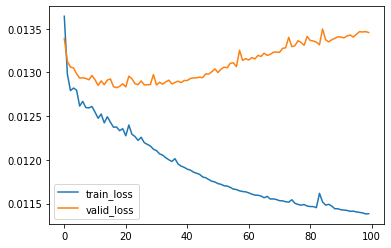

In [11]:
x = [i for i in range(len(train_loss_history))]
plt.plot(x, train_loss_history, label="train_loss")
plt.plot(x, valid_loss_history, label="valid_loss")
plt.legend()
plt.show()